In [257]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.environ['TEJAPI_KEY'] = "G3bD8xWb79qNk4gE5FHBD3NDvvsIsV"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

In [258]:
start = '2021-01-01'
end = '2023-12-31'
from zipline.sources.TEJ_Api_Data import get_universe
# 抓取台灣50指數的股票

#StockList = get_universe(start, end, mkt = 'TWSE', stktp_c = '普通股', main_ind_c=['M2300 電子工業','OTC23 OTC 電子類'])
StockList=['2330','2454','2455','2458','3014','3034','3529','4952','4961','5234','6183','6531','6756','6799','8016','8081','8261']
#StockList=['2330']
tickers = ' '.join(StockList)
os.environ['ticker'] =tickers+' IX0001'
os.environ['mdate'] = start+' '+end

# calendar------------------------------------------
calendar_name = 'TEJ_XTAI'  
# bundle_name---------------------------------------
bundle_name = 'tquant'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 12/1000 (1.2%)
Currently used TEJ API key data quota 54122/10000000 (0.54%)


[2024-06-11 17:38:19.001910] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-06-11 17:38:22.785822] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [259]:
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.sources.TEJ_Api_Data import get_Benchmark_Return

bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IX0001',as_of_date = None)
# 取所有sid
sids = bundle.asset_finder.equities_sids
# 取所有assets
assets = bundle.asset_finder.retrieve_all(sids)
# 取所有symbol
symbol = [i.symbol for i in assets]
# 用sid取assets
_asset = bundle.asset_finder.retrieve_equities([0,1])

In [260]:
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.mixins import SingleInputMixin
from numpy import (
    abs,
    average,
    clip,
    diff,
    dstack,
    inf,
)
from zipline.utils.math_utils import (
    nanargmax,
    nanargmin,
    nanmax,
    nanmean,
    nanstd,
    nanmin,
)
from numexpr import evaluate
class RSI2(SingleInputMixin, CustomFactor):
    """
    Relative Strength Index

    **Default Inputs**: :data:`zipline.pipeline.data.EquityPricing.close`

    **Default Window Length**: 15
    """
    window_length = 15
    inputs = (TWEquityPricing.close,)
    window_safe = True

    def compute(self, today, assets, out, closes):
        #print(closes)
        #print("try1")
        
        #print(closes[0:][:])
        #print("try2")
        
        diffs = diff(closes[:-1][:], axis=0)
        ups = nanmean(clip(diffs, 0, inf), axis=0)
        downs = abs(nanmean(clip(diffs, -inf, 0), axis=0))
        return evaluate(
            "100 - (100 / (1 + (ups / downs)))",
            local_dict={'ups': ups, 'downs': downs},
            global_dict={},
            out=out,
        )

In [261]:
from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline   
from zipline.pipeline.factors import SimpleMovingAverage, RSI
def make_pipeline(short,long):
    rsi_long = RSI(inputs = [TWEquityPricing.close], window_length = long)
    rsi_short = RSI(inputs = [TWEquityPricing.close], window_length = short)
    pre_rsi_long = RSI2(inputs = [TWEquityPricing.close], window_length = long+1)
    pre_rsi_short = RSI2(inputs = [TWEquityPricing.close], window_length = short+1)

    return Pipeline(columns={'curr_price':TWEquityPricing.close.latest,
                             "RSI_short": rsi_short,
                             "RSI_long": rsi_long,
                             "pre_RSI_short":  pre_rsi_short,
                             "pre_RSI_long":  pre_rsi_long
                            }
                   )

start_date = pd.Timestamp('2021-01-22',tz='utc')
end_date = pd.Timestamp('2023-12-31',tz='utc')
result = run_pipeline(make_pipeline(7,14), start_date, end_date)
#result.to_csv("rsi.csv")
result

curr_price  RSI_short  \
2021-01-22 00:00:00+00:00 Equity(0 [2330])         673.00  86.170213   
                          Equity(1 [2454])         934.00  67.361111   
                          Equity(2 [2455])         114.00  37.500000   
                          Equity(3 [2458])         168.50  52.272727   
                          Equity(4 [3014])          75.70  60.818713   
...                                                   ...        ...   
2023-12-29 00:00:00+00:00 Equity(13 [6799])        194.00  83.529412   
                          Equity(14 [8016])        276.00  44.000000   
                          Equity(15 [8081])        266.00  75.000000   
                          Equity(16 [8261])         97.20  46.153846   
                          Equity(17 [IX0001])    17910.37  80.034491   

                                                RSI_long  pre_RSI_short  \
2021-01-22 00:00:00+00:00 Equity(0 [2330])     92.024540      84.146341   
                          Equity(1 [2454])     77.734375      60.833333   
                          Equity(2 [2455])     43.333333      53.125000   
                          Equity(3 [2458])     78.787879      55.319149   
                          Equity(4 [3014])     64.372470      61.714286   
...                                                  ...            ...   
2023-12-29 00:00:00+00:00 Equity(13 [6799])    72.727273      83.132530   
                          Equity(14 [8016])    31.914894      50.000000   
                          Equity(15 [8081])    55.639098      51.515152   
                          Equity(16 [8261])    26.923077      43.902439   
                          Equity(17 [IX0001])  78.290919      81.629743   

                                               pre_RSI_long  
2021-01-22 00:00:00+00:00 Equity(0 [2330])        90.510949  
                          Equity(1 [2454])        70.618557  
                          Equity(2 [2455])        42.372881  
                          Equity(3 [2458])        78.571429  
                          Equity(4 [3014])        62.231760  
...                                                     ...  
2023-12-29 00:00:00+00:00 Equity(13 [6799])       67.619048  
                          Equity(14 [8016])       36.363636  
                          Equity(15 [8081])       40.404040  
                          Equity(16 [8261])       39.344262  
                          Equity(17 [IX0001])     78.670614  

[12557 rows x 5 columns]

In [262]:
from zipline.finance import slippage, commission
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost = 0.001425 + 0.003 / 2))
    attach_pipeline(make_pipeline(6, 12), 'mystrats')
    set_benchmark(symbol('IX0001'))

In [269]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')  
    
    for i in out_dir.index:
        sym = i.symbol
        RSI_short = out_dir.loc[i, 'RSI_short']
        RSI_long = out_dir.loc[i, "RSI_long"]
        pre_RSI_short = out_dir.loc[i, 'pre_RSI_short']
        pre_RSI_long = out_dir.loc[i, "pre_RSI_long"]
        curr_price = out_dir.loc[i, 'curr_price']
        
        cash_position = context.portfolio.cash    # 記錄現金水位
        stock_position = context.portfolio.positions[i].amount    # 記錄股票部位

        buy, sell = False, False

        record(
           **{
                f'price_{sym}':curr_price,
                f'RSI_short_{sym}':RSI_short,
                f'RSI_long_{sym}':RSI_long,
                f'pre_RSI_short_{sym}':pre_RSI_short,
                f'pre_RSI_long_{sym}':pre_RSI_long,
                f'buy_{sym}':buy,
                f'sell_{sym}':sell
            }
        )
        if (pre_RSI_short is None) or (pre_RSI_long is None):
            pass
        else:
        
            if stock_position == 0 :
                if (20 <= RSI_short <= 70) and (pre_RSI_long > pre_RSI_short) and (RSI_short > RSI_long)  and (cash_position >= curr_price * 1000):
                    order(i, 1000)
                    buy = True
                    record(
                        **{
                            f'buy_{sym}':buy
                        }
                    )
                else:
                    pass
            elif stock_position > 0  :
                if (RSI_short > 25) and (RSI_short < 65) and (pre_RSI_long > pre_RSI_short) and (RSI_short > RSI_long) and (cash_position >= curr_price * 1000):
                    order(i, 1000)
                    buy = True
                    record(
                        **{
                            f'buy_{sym}':buy
                        }
                    )
                elif (RSI_short >= 80) and(pre_RSI_short > pre_RSI_long) and (RSI_long > RSI_short) and (stock_position > 0):
                    order_target(i, 0)
                    sell = True
                    record(
                        **{
                            f'sell_{sym}':sell
                        }
                    )
                else:
                    pass
            else:
                pass


In [270]:
def analyze(context, perf):
    pass

In [271]:
from zipline import run_algorithm
start_d=pd.Timestamp('2021-01-22',tz='utc')
results = run_algorithm(
    start = start_d,
    end = end_date,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=5e6,
    handle_data = handle_data
)

In [272]:
#results.to_csv("try.csv")
results

,period_open,period_close,orders,net_leverage,ending_value,long_exposure,long_value,returns,short_exposure,positions,...,benchmark_volatility,max_leverage,treasury_period_return,price_6799,RSI_short_6799,RSI_long_6799,pre_RSI_short_6799,pre_RSI_long_6799,buy_6799,sell_6799
2021-01-22 13:30:00+08:00,2021-01-22 09:01:00+08:00,2021-01-22 13:30:00+08:00,"[{'id': '14602ba7ef3d49ac9a7b4e647c3cf1b5', 'd...",0.000000,0.0,0.0,0.0,0.000000e+00,0.0,[],...,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-25 13:30:00+08:00,2021-01-25 09:01:00+08:00,2021-01-25 13:30:00+08:00,"[{'id': '14602ba7ef3d49ac9a7b4e647c3cf1b5', 'd...",0.083500,417500.0,417500.0,417500.0,-5.852263e-07,0.0,"[{'sid': Equity(5 [3034]), 'amount': 1000, 'co...",...,0.042833,0.083500,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-26 13:30:00+08:00,2021-01-26 09:01:00+08:00,2021-01-26 13:30:00+08:00,"[{'id': '8f088b6def594af8b4631e1c90e3a95a', 'd...",0.139449,695920.0,695920.0,695920.0,-1.902986e-03,0.0,"[{'sid': Equity(5 [3034]), 'amount': 1000, 'co...",...,0.110614,0.139449,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-27 13:30:00+08:00,2021-01-27 09:01:00+08:00,2021-01-27 13:30:00+08:00,"[{'id': 'ad0320eabbe04ce9a641080bfee64cac', 'd...",0.177789,887750.0,887750.0,887750.0,5.579622e-04,0.0,"[{'sid': Equity(5 [3034]), 'amount': 1000, 'co...",...,0.137264,0.177789,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-28 13:30:00+08:00,2021-01-28 09:01:00+08:00,2021-01-28 13:30:00+08:00,"[{'id': '44cce29a7bfa47db82afeb4a3a5ed314', 'd...",0.181549,901400.0,901400.0,901400.0,-5.648193e-03,0.0,"[{'sid': Equity(5 [3034]), 'amount': 1000, 'co...",...,0.142782,0.181549,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,[],0.996829,8812669.5,8812669.5,8812669.5,1.361880e-02,0.0,"[{'sid': Equity(12 [6756]), 'amount': 7000, 'c...",...,0.168712,1.075511,0.0,182.5,89.473684,78.260870,71.428571,69.863014,False,False
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,[],0.996891,8986258.0,8986258.0,8986258.0,1.963516e-02,0.0,"[{'sid': Equity(12 [6756]), 'amount': 7000, 'c...",...,0.168663,1.075511,0.0,175.5,71.014493,60.000000,89.473684,78.260870,False,False
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,[],0.996926,9090523.5,9090523.5,9090523.5,1.156669e-02,0.0,"[{'sid': Equity(12 [6756]), 'amount': 7000, 'c...",...,0.168607,1.075511,0.0,181.0,81.081081,65.263158,71.014493,60.000000,False,False
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,[],0.996912,9048781.0,9048781.0,9048781.0,-4.577755e-03,0.0,"[{'sid': Equity(12 [6756]), 'amount': 7000, 'c...",...,0.168489,1.075511,0.0,185.5,79.411765,69.607843,81.081081,65.263158,False,False


<Axes: >

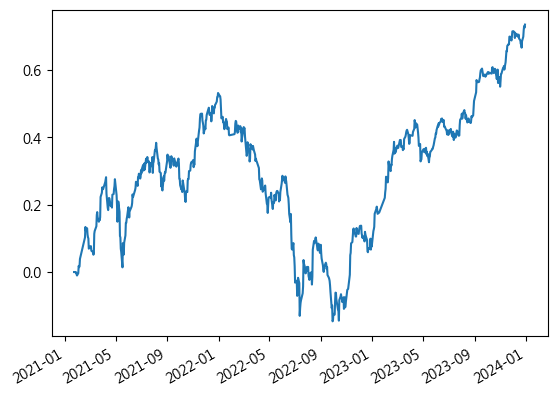

In [273]:
results.returns.cumsum().plot()

Start date,2021-01-22
End date,2023-12-29
Total months,34
,Backtest
Annual return,23.79%
Cumulative returns,83.22%
Annual volatility,30.152%
Sharpe ratio,0.86
Calmar ratio,0.46
Stability,0.07
Max drawdown,-51.443%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,51.44,2021-12-30,2022-10-13,2023-10-13,431
1,24.45,2021-04-08,2021-05-17,2021-06-30,58
2,16.85,2021-08-05,2021-10-14,2021-11-09,66
3,8.00,2021-02-18,2021-03-09,2021-03-17,19
4,5.84,2023-10-13,2023-10-31,2023-11-09,20


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Stress Events,mean,min,max
New Normal,0.10%,-9.72%,8.02%


Top 10 long positions of all time,max
sid,
3034,40.40%
2454,31.35%
3529,29.49%
6531,28.78%
6756,21.01%
2330,18.97%
2455,14.02%
4961,11.87%
8016,11.25%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3034,40.40%
2454,31.35%
3529,29.49%
6531,28.78%
6756,21.01%
2330,18.97%
2455,14.02%
4961,11.87%
8016,11.25%


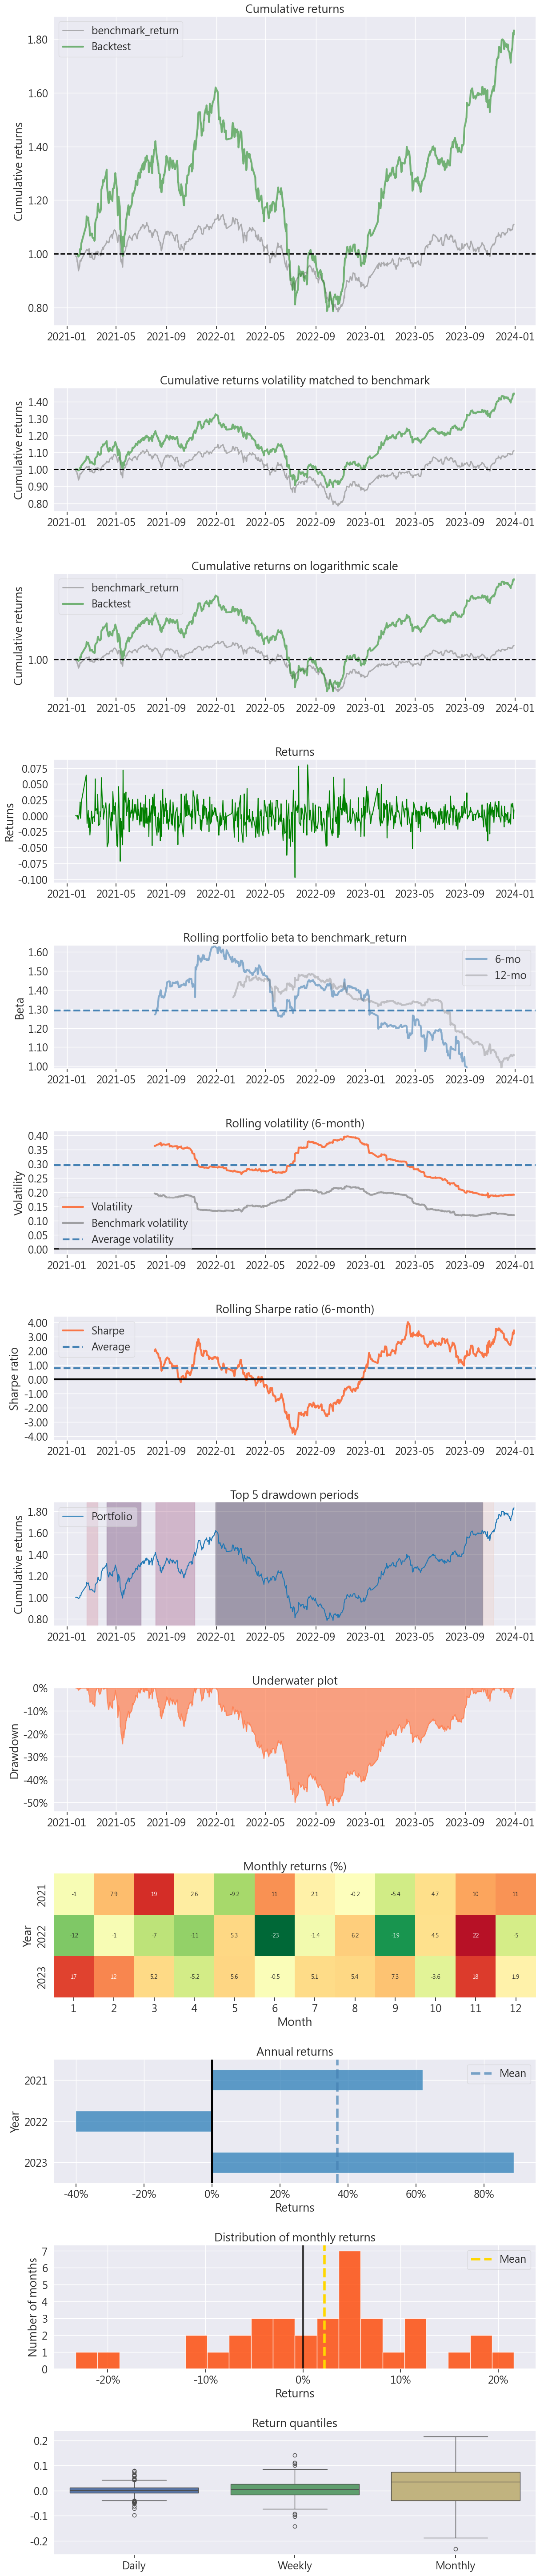

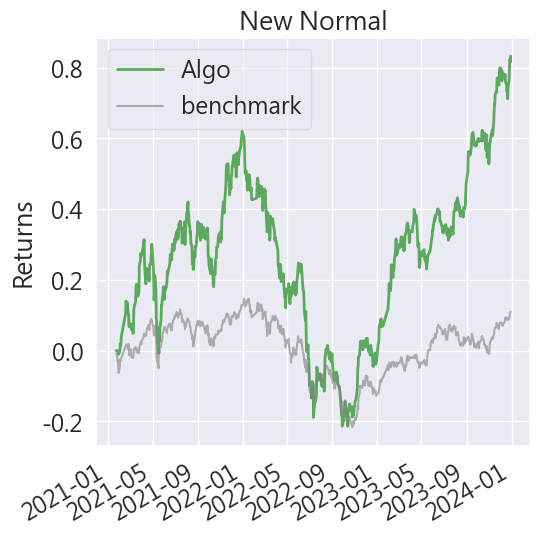

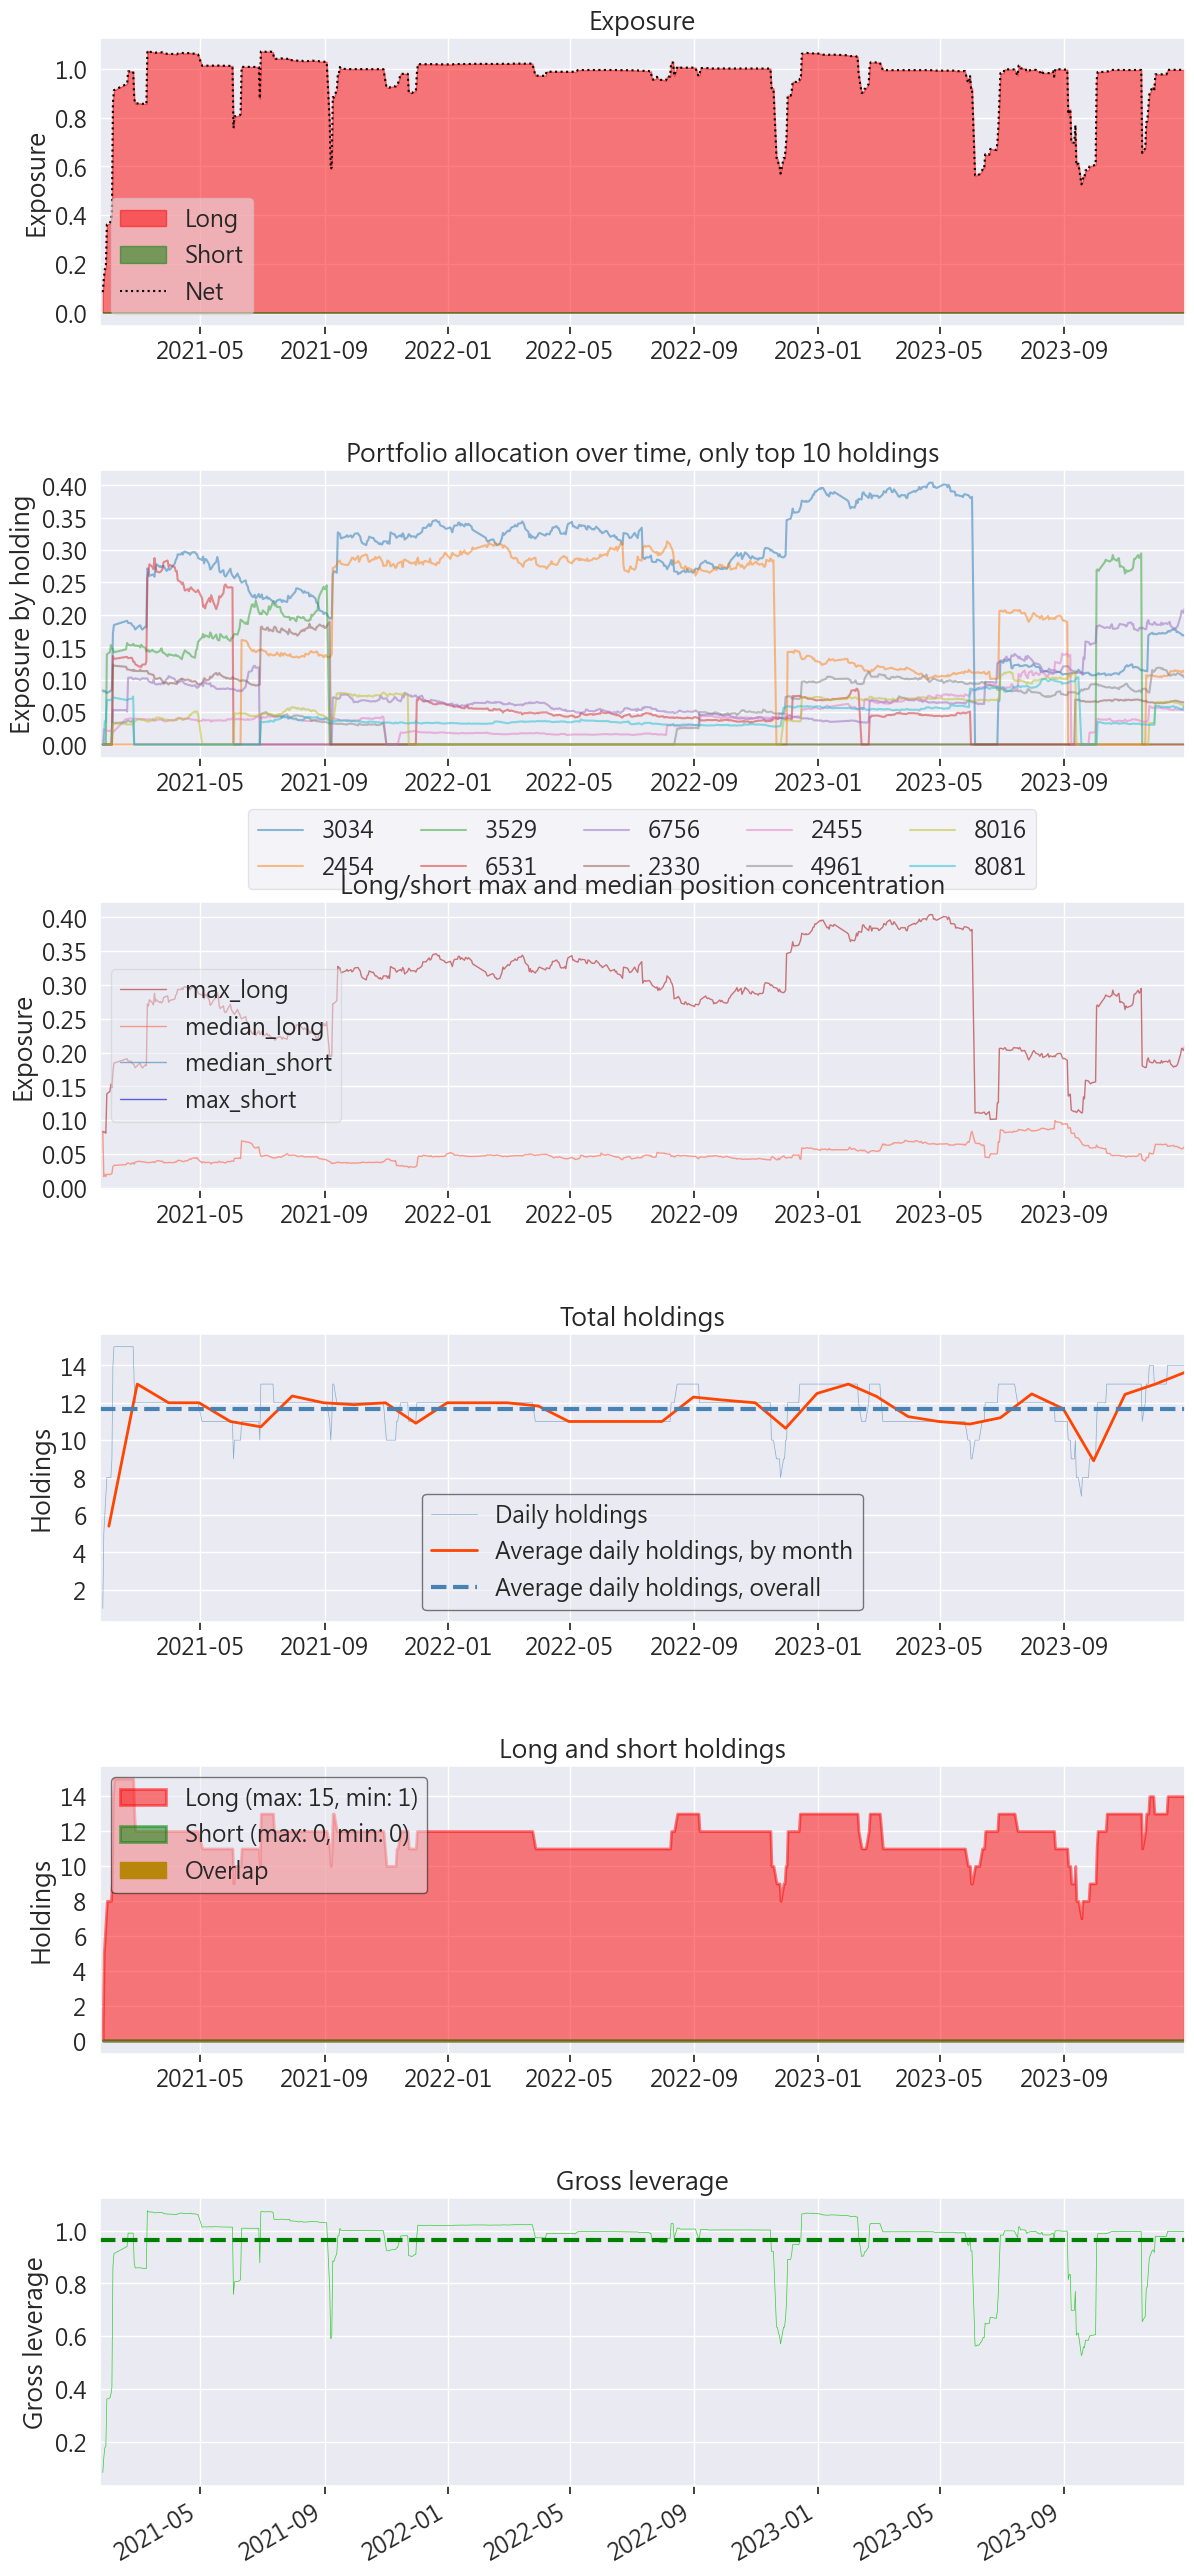

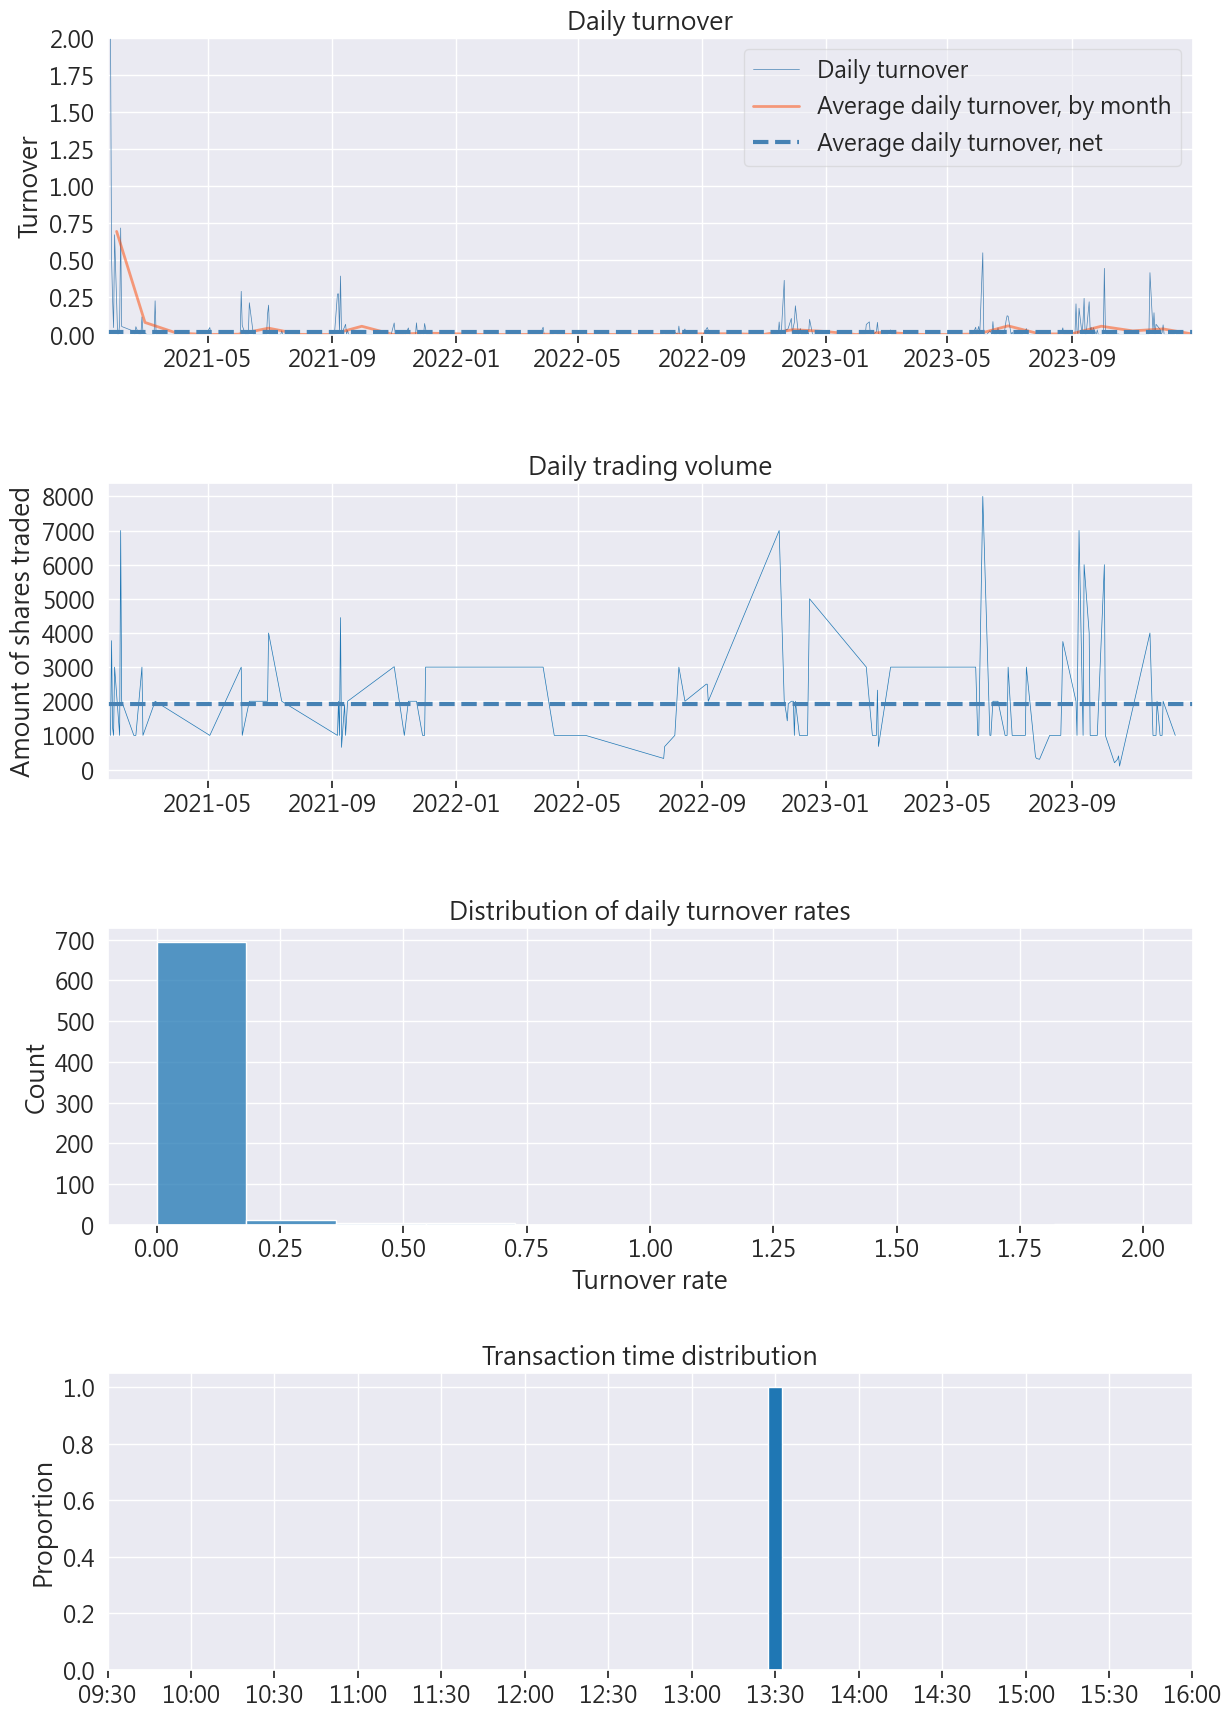

In [274]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                          benchmark_rets = benchmark_rets,
                          round_trips=False)